<a href="https://colab.research.google.com/github/SunGod1998/Summer_Internship_2020/blob/master/DeepTrack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))   

Saving Price_All.csv to Price_All.csv
User uploaded file "Price_All.csv" with length 1527571 bytes


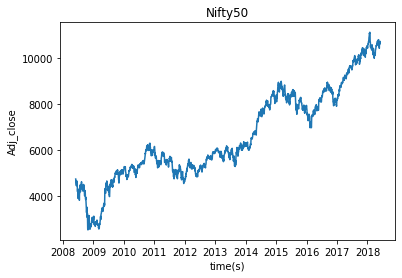

In [4]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf

df=pd.read_csv("Price_All.csv")
df.dropna(inplace=True)
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
scaler=MinMaxScaler()

fig, ax = plt.subplots()
ax.plot(df["Date"], df["Price_51"])

ax.set(xlabel='time(s)', ylabel='Adj_close',
       title='Nifty50')
fig.savefig("benchmark.png")
plt.show()

In [5]:
#Implementing the seq2seq LSTM autoencoder and extract the top K stocks 
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model

df.head(3)
X_AE=df.drop("Date",axis=1)
scaled_X_AE=scaler.fit_transform(X_AE)
Data=scaled_X_AE
Data=np.reshape(Data,(1,Data.shape[0],Data.shape[1]))
model = Sequential()
model.add(LSTM(80, activation='relu', input_shape=(Data.shape[1],Data.shape[2]),return_sequences=True,name='Enc_1'))
model.add(TimeDistributed(Dropout(0.2)))
model.add(LSTM(50, activation='relu', return_sequences=True,name='Enc_1_1'))
model.add(TimeDistributed(Dense(Data.shape[2]),name='dec_1'))
model.compile(optimizer='adam', loss='mse')

hist=model.fit(Data,Data,epochs=80,batch_size=1)

model=Model(inputs=model.inputs, outputs=model.layers[3].output)
decoded_data=model.predict(Data)
decoded_data.shape


Epoch 1/80
1/1 [==============================] - 4s 4s/step - loss: 0.1992
Epoch 2/80
1/1 [==============================] - 2s 2s/step - loss: 0.1843
Epoch 3/80
1/1 [==============================] - 2s 2s/step - loss: 0.1667
Epoch 4/80
1/1 [==============================] - 2s 2s/step - loss: 0.1477
Epoch 5/80
1/1 [==============================] - 2s 2s/step - loss: 0.1334
Epoch 6/80
1/1 [==============================] - 2s 2s/step - loss: 0.1217
Epoch 7/80
1/1 [==============================] - 2s 2s/step - loss: 0.1114
Epoch 8/80
1/1 [==============================] - 2s 2s/step - loss: 0.1014
Epoch 9/80
1/1 [==============================] - 2s 2s/step - loss: 0.0960
Epoch 10/80
1/1 [==============================] - 2s 2s/step - loss: 0.0867
Epoch 11/80
1/1 [==============================] - 2s 2s/step - loss: 0.0805
Epoch 12/80
1/1 [==============================] - 2s 2s/step - loss: 0.0762
Epoch 13/80
1/1 [==============================] - 2s 2s/step - loss: 0.0711
Epoch 14

(1, 2441, 47)

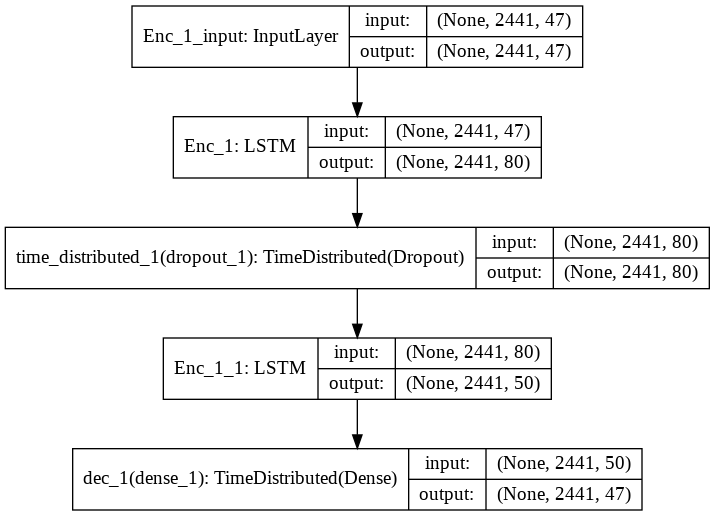

In [6]:
plot_model(model,show_shapes=True,show_layer_names=True)

[13 31 33 22  2 44 18 32 17 25  1 35 45 21  7 46  8 43 14 42  5 15 24 10
 26 38 29  4 39  3 40 20 19 36 34 23 27 37  6 28 41 11 16 47 30  9 12]


'\ns=np.max(s,axis=0)\ncolumns=np.asarray(df.columns[1:-1])\n\ncol_05=ma.masked_array(columns,mask=mask_05)\ncolumns_used=list(col_05.compressed())\ncolumns_used\n'

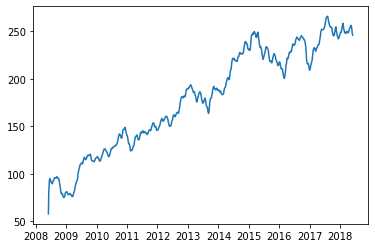

In [7]:
import numpy as np

d_1=np.reshape(Data,(Data.shape[1],Data.shape[2]))
d_2=np.reshape(decoded_data,(Data.shape[1],Data.shape[2]))
d_1=scaler.inverse_transform(d_1)
d_2=scaler.inverse_transform(d_2)
rep_data=d_1-d_2

sim=np.linalg.norm(rep_data,axis=0)
ind=np.argsort(sim)+1
print(str(ind))
plt.plot(df.index,d_2[:,1])

'''
s=np.max(s,axis=0)
columns=np.asarray(df.columns[1:-1])

col_05=ma.masked_array(columns,mask=mask_05)
columns_used=list(col_05.compressed())
columns_used
'''

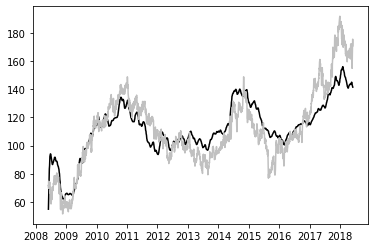

In [12]:
#CHECKPOINT: De-noised(Black) vs Original(Silver)
plt.plot(df.index,d_2[:,12],'black',df.index,d_1[:,12],'silver')

In [0]:
Y=df["Price_51"]
Y=np.asarray(Y)

X=df[df.columns[ind[1:41]]]
X=scaler.fit_transform(X)

Y=Y.reshape((Y.shape[0],1))
Y=scaler.fit_transform(Y)

In [166]:
from sklearn.model_selection import train_test_split

import numpy as np

X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size=0.30,shuffle=False)
[X_train.shape,X_test.shape,y_train.shape,y_test.shape]

[(1708, 40), (733, 40), (1708, 1), (733, 1)]

https://roamanalytics.com/2016/11/28/shape-matching-with-time-series-data/


The following portion uses the LSTM based architecture to predict the performance of the tracker

In [167]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, RepeatVector,CuDNNLSTM, SimpleRNN, GRU
from keras.utils import plot_model
from keras.losses import KLDivergence
import keras
import datetime
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers

X_train = np.reshape(X_train, (X_train.shape[0], X.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0], X.shape[1], 1))

model=Sequential()
model.add(LSTM(80,activation='relu',input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True,kernel_regularizer=regularizers.l1(1e-4)))
#model.add(TimeDistributed(Dropout(0.2)))
model.add(SimpleRNN(100,activation='relu',input_shape=(X_train.shape[1], X_train.shape[2]),kernel_regularizer=regularizers.l1(1e-4)))
model.add(Dense(1))

#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=100000, decay_rate=0.96,staircase=True)

opt = keras.optimizers.Adam(learning_rate=0.001,decay=1e-5)

model.compile(loss="mse",optimizer=opt)

history=model.fit(X_train, y_train, epochs=7
                  , batch_size=10, validation_data=(X_test,y_test))
#model.summary()

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(y_test)



Train on 1708 samples, validate on 733 samples
Epoch 1/7
1708/1708 [==============================] - 6s 3ms/step - loss: 0.0465 - val_loss: 0.0180
Epoch 2/7
1708/1708 [==============================] - 5s 3ms/step - loss: 0.0122 - val_loss: 0.0109
Epoch 3/7
1708/1708 [==============================] - 5s 3ms/step - loss: 0.0065 - val_loss: 0.0050
Epoch 4/7
1708/1708 [==============================] - 5s 3ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 5/7
1708/1708 [==============================] - 5s 3ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 6/7
1708/1708 [==============================] - 5s 3ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 7/7
1708/1708 [==============================] - 5s 3ms/step - loss: 0.0012 - val_loss: 0.0013


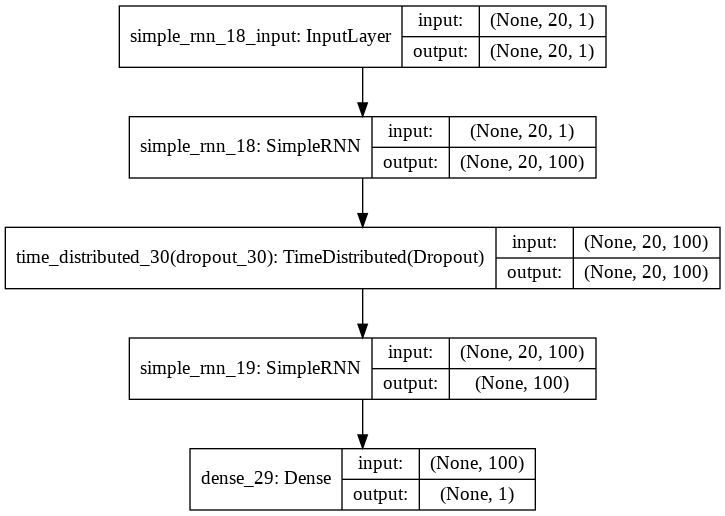

In [103]:
plot_model(model,show_shapes=True)


Now that the model has been built, we verify it's efficacy in the validation set by ploting both the benchmark as well as the tracker values

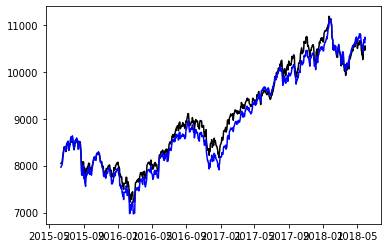

In [168]:
##tracker(black) vs benchmark(blue) in the testing phase
plt.plot(df.index[-Y_test.shape[0]:],test_predict,'black',df.index[-Y_test.shape[0]:],Y_test,'b-')

Testing starts on :2015-06-11 00:00:00


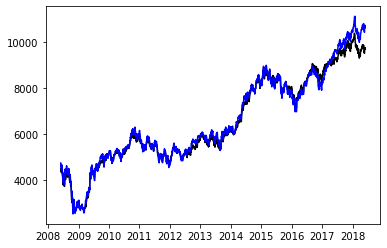

In [164]:
#tracker(black) vs benchmark(blue) over the entire timeline
predicted=np.concatenate((train_predict,test_predict))
plt.plot(df.index, predicted, 'black', df.index, df["Price_51"], 'blue')
test_start_date=df.index[-y_test.shape[0]]

print("Testing starts on :"+str(test_start_date))

Now that I have obtained my predicted time series, I intend to use one of the similarity measures proposed by Mori et al. with their respctive implementation in the **TSDist** library in R.   

In [133]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

base=importr('base')
stats=importr('stats')
ro.r('install.packages("TSdist")')

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/TSdist_3.6.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 472146 bytes (461 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write t

<rpy2.rinterface.NULLType object at 0x7f4989bb9608> [RTYPES.NILSXP]

In [0]:
TSDist=importr('TSdist')

In [169]:
predicted=np.reshape(predicted,(predicted.shape[0],))
p=pd.Series(predicted,copy=True)
tracker=base.as_numeric(predicted.tolist())
benchmark=base.as_numeric(df["Price_51"].tolist())
dist=TSDist.CCorDistance(tracker, benchmark)
dist

0.005332
